# Twitter Languagemodel Creator

In [1]:
import csv
import json
import warnings

from fastai.fastai.text import *

warnings.filterwarnings('ignore')

C:\Users\leond\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Define working paths and tags

In [2]:
PATH = Path("wiwo/")
BOS = "xbos " #beginning-of-sentence tag
BOD = " xbody "
TIT = " xtitle "
LEAD = " xlead "
TPC = " xtopic "

CLAS_PATH = Path("wiwo_clas/")
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path("wiwo_lm/")
LM_PATH.mkdir(exist_ok=True)

In [5]:
def get_texts(path):
    texts, data = [], {}
    
    with open(path, "r") as dataset:
        data = json.load(dataset)
    dataset.close()
    for entry in data[:13000]:
        try:
            texts.append(BOS+TPC+entry["topic"]+TIT+entry["title"].strip()+LEAD+entry["leadtext"].strip()+BOD+entry["body"])
        except:
            pass
    return np.array(texts)



In [6]:
col_names = ["labels", "text"]

In [7]:
trn_texts = get_texts(PATH/"output-all.json")

ratio = 10

trn_texts = trn_texts

val_texts = trn_texts[:int(len(trn_texts)/ratio)]
trn_texts = trn_texts[int(len(trn_texts)/ratio):]

In [8]:
len(trn_texts), len(val_texts)

(11655, 1295)

In [9]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

trn_txts = trn_texts[trn_idx]
val_txts = val_texts[val_idx]

In [10]:
len(trn_txts), len(val_txts)

(11655, 1295)

In [11]:
df_trn = pd.DataFrame({"text":trn_txts, "labels":[0]*len(trn_txts)}, columns=col_names)
df_val = pd.DataFrame({"text":val_txts, "labels":[0]*len(val_txts)}, columns=col_names)

In [12]:
df_trn.to_csv(LM_PATH/"train.csv", header=False, index=False)
df_val.to_csv(LM_PATH/"valid.csv", header=False, index=False)

In [13]:
df_trn.head()

,labels,text
0,0,xbos xtopic Fehler im Kreditvertrag xtitle VW...
1,0,xbos xtopic Syrien-Einsatz der Bundeswehr xti...
2,0,xbos xtopic Wirtschaftswissenschaften xtitle ...
3,0,xbos xtopic AfD im Bundestag xtitle Tapferkei...
4,0,xbos xtopic Forsa-Umfrage xtitle Es wird knap...


## Tokenization

In [19]:
chunksize = 3000
                 
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += df[i].astype(str)
    texts = list(texts)
    
    tok = Tokenizer(lang="de").proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [15]:
tokx = Tokenizer(lang="de")

In [16]:
tokx.tok

In [17]:
def get_all(df, n_lbls=1):
    tok, labels = [],[]
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [18]:
df_trn = pd.read_csv(LM_PATH/"train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/"valid.csv", header=None, chunksize=chunksize)

In [20]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
0


In [21]:
(LM_PATH/"tmp").mkdir(exist_ok=True)

In [22]:
np.save(LM_PATH/"tmp"/"tok_trn.npy",tok_trn)
np.save(LM_PATH/"tmp"/"tok_val.npy",tok_val)

In [23]:
tok_trn = np.load(LM_PATH/"tmp"/"tok_trn.npy")
tok_val = np.load(LM_PATH/"tmp"/"tok_val.npy")

In [24]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('.', 555389),
 (',', 458962),
 ('die', 345835),
 ('der', 301022),
 ('und', 180778),
 ('-', 168352),
 ('in', 158211),
 ('\r\n \r\n \r\n ', 142207),
 ('das', 118203),
 ('den', 109035),
 ('von', 89364),
 (':', 85833),
 ('zu', 82791),
 ('für', 82602),
 ('„', 82235),
 ('mit', 80479),
 ('“', 79976),
 ('ist', 79440),
 ('auf', 74821),
 ('i', 74138),
 ('m', 74002),
 ('nicht', 69393),
 ('sich', 68417),
 ('t_up', 65603),
 ('ein', 64830)]

In [25]:
len(freq),len([value for value in freq.values() if value >= 5])

(271918, 71791)

In [26]:
max_vocab = 50000
min_freq = 5

In [27]:
itos = [o for o,c in freq.most_common(max_vocab) if c>=min_freq]
itos.insert(0, "_unk_")
itos.insert(1, "_pad_")

In [28]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

50002

In [29]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

np.save(LM_PATH/"tmp"/"trn_ids.npy", trn_lm)
np.save(LM_PATH/"tmp"/"val_ids.npy", val_lm)

pickle.dump(itos, open(LM_PATH/"tmp"/"itos.pkl","wb"))

In [30]:
#necessary
vs = len(itos) #vocabsize
vs, len(trn_lm), len(val_lm)

(50002, 11655, 1295)

## Language Model

In [49]:
em_sz, nh, nl = 400,1150,3

bptt=60
bs=30 #biggest batch size possible for quicker learning - Figure 6 https://arxiv.org/pdf/1803.09820.pdf
wd=1e-7 #https://arxiv.org/pdf/1803.09820.pdf - smaller wd for large learning rates for super convergence Figure 5 b)
# Smaller datasets and architectures seem to require larger values for weight decay while larger datasets and
# deeper architectures seem to require smaller values. Our hypothesis is that complex data provides
# its own regularization and other regularization should be reduced.
opt_fn = partial(optim.Adam, betas=(0.8,0.99))

In [50]:
trn_lm = np.load(LM_PATH/"tmp"/"trn_ids.npy")
val_lm = np.load(LM_PATH/"tmp"/"val_ids.npy")
itos = pickle.load(open(LM_PATH/"tmp"/"itos.pkl","rb"))

vs = len(itos)
vs, len(trn_lm), len(val_lm)

(50002, 11655, 1295)

In [58]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [59]:
md.trn_dl.data = md.trn_dl.data.long()
md.val_dl.data = md.val_dl.data.long()

In [60]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15], dtype="f")*0.8

In [61]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip= 0.12
learner.unfreeze()
learner.get_layer_groups()
learner.freeze_to(-1)

In [62]:
learner.lr_find2(start_lr=10e-2, end_lr=1, num_it=100)
learner.sched.plot()

  2%|█                                                                   | 100/6301 [00:16<16:50,  6.14it/s, loss=7.59]

RuntimeError: Error(s) in loading state_dict for SequentialRNN:
	Missing key(s) in state_dict: "0.rnns.0.module.weight_hh_l0", "0.rnns.1.module.weight_hh_l0", "0.rnns.2.module.weight_hh_l0". 

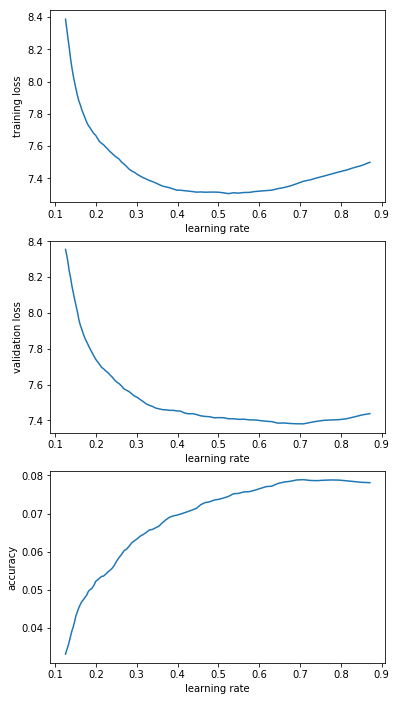

In [63]:
learner.sched.plot()

In [64]:
lr = 0.3

In [65]:
learner.fit(lr/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

#learner.fit(lr, 1,use_clr_beta=(10,10,0.95,0.85), cycle_len=10, best_save_name="best_lm")

epoch      trn_loss   val_loss   accuracy                                                                              
    0      6.235656   6.156637   0.149365  


[6.156636630074453, 0.14936513922224612]

In [66]:
learner.save('lm_last_ft')

In [67]:
learner.load('lm_last_ft')

In [68]:
learner.unfreeze()

  2%|█                                                                   | 100/6301 [00:17<18:47,  5.50it/s, loss=6.26]

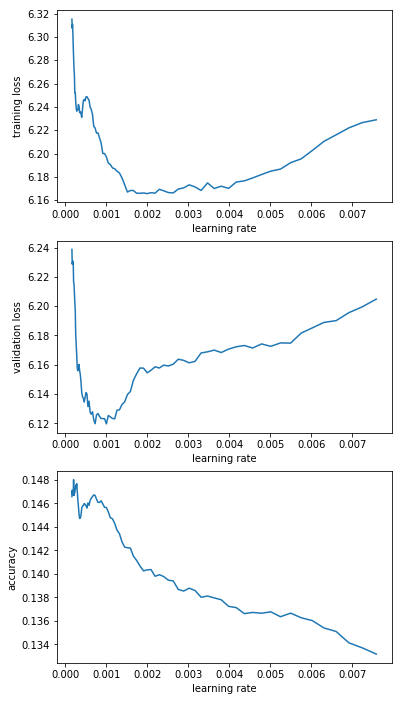

In [69]:
learner.lr_find2(start_lr=10e-5, end_lr=1e-2, num_it=100)
learner.sched.plot()

In [70]:
lr = 0.0005

In [71]:
learner.fit(lr, 1, wds=wd, use_clr=(20,10), cycle_len=15) 

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.198033   5.313092   0.220447  
    1      4.948634   5.077777   0.24436                                                                               
    2      4.820629   4.943106   0.257128                                                                              
    3      4.710794   4.860695   0.261835                                                                              
    4      4.650839   4.799568   0.268671                                                                              
    5      4.612399   4.756218   0.273069                                                                              
    6      4.552402   4.725918   0.27602                                                                               
    7      4.545306   4.70086    0.278028                                                                           

[4.635968591399112, 0.2837371841325598]

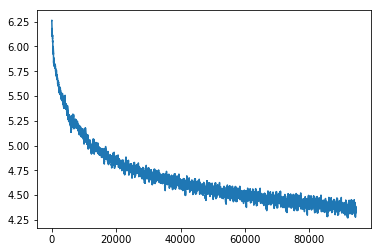

In [72]:
learner.sched.plot_loss()

In [74]:
learner.save("wiwo_lm_german")
learner.save_cycle("wiwo_lm_german_cyc", 14)
learner.save_encoder("wiwo_lm_german_enc")


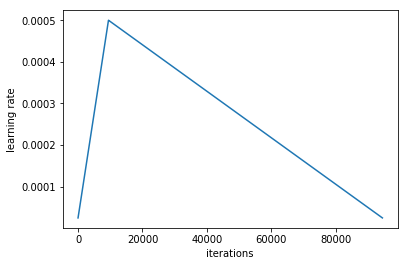

In [75]:
learner.sched.plot_lr()

In [76]:
learner.load("wiwo_lm_german")

## Evaluate 

In [77]:
#from https://github.com/cedrickchee/data-science-notebooks/blob/master/notebooks/deep_learning/ULMFiT/malay_language_model.ipynb

In [78]:
m = learner.model # initialized model
m.eval() # ensure you switch your model to inference mode
m[0].bs = 1 # set batch size to 1

In [79]:
# Load the index-word mapping from the picked file on disk to help us convert the indexes to words.
itos = pickle.load(open(LM_PATH / "tmp" / "itos.pkl", "rb"))

# String to index lambda function
stoi = collections.defaultdict(lambda: 0, {v:k for k, v in enumerate(itos)})
len(itos)

50002

In [80]:
# Utility functions
from random import randint

def gen_text(ss, topk):
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]

    return [itos[o] for o in to_np(pred_i)]

def generate_sentences(ss, nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    
    for i in range(nb_words):
        pred_i = pred[-1].topk(3)[1]
        idx = randint(1,len(pred_i)-1)
        pred_i = pred_i[idx] #if pred_i.data[0] < 1 else pred_i[1]
        if pred_i.data[0] != 0:
            word = itos[pred_i.data[0]]
            result.append(word)
            pred, *_ = m((pred_i[0].unsqueeze(0).expand(1,2)))
        
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))

    return(result)

In [81]:
strings = [
    BOS,
    "Der heute",
    "Alles Weitere"
]

In [82]:
for s in strings:
    print(f"{s}... \n{generate_sentences(s.lower(), 400)}\n")

xbos ... 
xbos  aus der schweiz, der türkei, österreich und schweden, aber nicht mit der schweiz und deutschland zusammen, um das zu ändern und das wachstum in der euro zu verbessern, sondern die zahl seiner beschäftigten i diesem land auf rund 20 prozent steigern. das heißt aber, sie würden die zahl von derzeit knapp fünf prozent i diesem vergleich erhöhen, wenn es zu einem weiteren rückgang der nachfrage kommen könnte, wenn sich der markt für den gesamten markt in deutschland weiter erholen wird, so die studie der t_up oecd, der die zeitung in seiner „ zeit " veröffentlicht. 
 
 
  der europäische markt ist i diesem vergleich zu 2012 um ein drittel gewachsen, während der umsatz in den letzten drei monaten von knapp zehn prozent um zwei drittel gestiegen war, und die zahl auf rund 50 prozent der wirtschaftsleistung steigen soll, so dass es in der vergangenheit auch auf den deutschen mittelstand nicht ankommt : so stieg der durchschnittliche durchschnittliche haushalt der bundesrepubli

In [202]:
math.exp(4.05)

57.39745704544619

In [83]:
wgts =  torch.load(PATH/"models"/"lm0_fit_wt103_based.h5", map_location=lambda storage, loc: storage)

In [84]:
import re

def to_tensorboard(tensor, itos):
    pattern = re.compile(r'(\n\s){2,}')
    new_tensor = ["\t".join(map(str, to_np(vector).tolist())) for vector in tensor]
    print(len(new_tensor), len(itos))
    with open("wt103_sem140.tsv", "w") as output:
        for vector in new_tensor:
            output.write("%s\n" % vector)
    with open("itos_tf_learned.tsv","wb") as f:
        for i, word in enumerate(itos):
            word = "'{}'\n".format(repr(word))
            word = word.encode("utf-8")
            f.write(word)

In [85]:
to_tensorboard(wgts["0.encoder.weight"],itos)

50002 50002
